In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md
plt.rc('font',family='serif')
%matplotlib inline

In [2]:
# get filenames of the trajectories
from glob import glob
fnames = glob('abl_snapshot/*.h5')
print(len(fnames),fnames[0])

(253, 'abl_snapshot/run11-clone9.h5')


In [3]:
from msmbuilder.featurizer import DihedralFeaturizer

# retrofitting the dihedral featurizer to keep track of which atoms correspond
# to which elements of the feature vector, so that we can interpret these later
class LabeledDihedralFeaturizer(DihedralFeaturizer):
    def partial_transform(self,traj):
        x = []
        self.labels = []
        self.atom_list = []
        
        for a in self.types:
            func = getattr(md, 'compute_%s' % a)
            atoms,y = func(traj)
            self.labels.append(a)
            if self.sincos:
                self.atom_list.append(np.vstack([atoms]*2))
                
                x.extend([np.sin(y), np.cos(y)])
            else:
                self.atom_list.append(atoms)
                
                x.append(y)

        self.atom_list = np.vstack(self.atom_list)
        return np.hstack(x)
    
dih_model = LabeledDihedralFeaturizer(['phi', 'psi', 'omega', 'chi1', 'chi2', 'chi3', 'chi4'])

In [4]:
Xs = []
ys = []

for ind,fname in enumerate(fnames):
    i = fname.find('run')
    j = fname.find('-')
    run = (int(fname[i+3:j]))
    
    try:
        x = dih_model.fit_transform([md.load(fname)])[0]
        Xs.append(x)
        ys.append(np.ones(len(x))*run)
    except:
        pass

In [6]:
# one of the files is corrupt
len(Xs),len(fnames)

(252, 253)

In [7]:
X = np.vstack(Xs)
y = np.hstack(ys)
X.shape,y.shape,len(set(y))

((604192, 2478), (604192,), 13)

In [8]:
np.save('dihedrals.npy',X)
np.save('run_labels.npy',y)

In [ ]:
X = np.load('dihedrals.npy')
y = np.load('run_labels.npy')

In [9]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion='entropy',max_depth=5)

In [27]:
dt.fit(X[::50],y[::50])

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

In [28]:
dt.score(X,y)

0.9659942534823367

In [29]:
dt.feature_importances_

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [30]:
# how many features does this classifier look at?
sum(dt.feature_importances_!=0)

22

(0, 1)

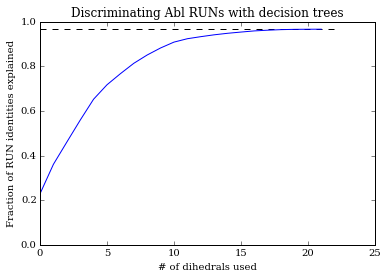

In [31]:
# how does the accuracy increase as we include more features
plt.plot(np.cumsum(sorted(dt.feature_importances_[dt.feature_importances_!=0])[::-1])*dt.score(X,y))
plt.hlines(dt.score(X,y),0,sum(dt.feature_importances_!=0),linestyles='--')
plt.xlabel('# of dihedrals used')
plt.ylabel('Fraction of RUN identities explained')
plt.title('Discriminating Abl RUNs with decision trees')
plt.ylim(0,1)

In [32]:
feature_importances = dt.feature_importances_[dt.feature_importances_!=0]

In [33]:
sorted_inds = np.array(sorted(np.arange(len(feature_importances)),key=lambda i:-feature_importances[i]))

In [34]:
sorted_inds

array([11,  1, 10, 20, 21,  0,  2, 13,  6, 16,  3, 15, 14, 17,  4,  9, 18,
        7,  8, 12, 19,  5])

In [35]:
y_pred = dt.predict(X)

In [36]:
# which runs have at least one frame incorrectly discriminated
len(set(y[y_pred!=y])),len(set(y))
# all of them

(13, 13)

In [37]:
# which quadruplets of atoms do the features correspond to?
_ = dih_model.fit_transform(md.load_frame(fnames[0],0))
atom_list = dih_model.atom_list

In [38]:
atom_list[dt.feature_importances_!=0][sorted_inds]

array([[2302, 2304, 2319, 2321],
       [1966, 1968, 1970, 1990],
       [1088, 1089, 1100, 1102],
       [2689, 2691, 2694, 2697],
       [3891, 3894, 3897, 3899],
       [ 553,  555,  557,  565],
       [2147, 2149, 2151, 2161],
       [2332, 2334, 2354, 2356],
       [ 334,  336,  354,  356],
       [1089, 1100, 1102, 1103],
       [2330, 2332, 2334, 2354],
       [1051, 1071, 1073, 1075],
       [2413, 2415, 2423, 2425],
       [2687, 2689, 2691, 2694],
       [ 540,  542,  553,  555],
       [ 735,  737,  743,  745],
       [3093, 3095, 3097, 3099],
       [ 518,  520,  538,  540],
       [ 598,  600,  611,  613],
       [2321, 2323, 2330, 2332],
       [2830, 2832, 2834, 2836],
       [  91,   93,  111,  113]])

In [39]:
# convert from atom index to residue number
traj = md.load_frame(fnames[0],0)
top = traj.topology

In [40]:
# print out the dihedrals using the residue names
important_dihedrals = atom_list[dt.feature_importances_!=0][sorted_inds]

def dihedral_to_string(quadruplet,top):
    ''' quadruplet is a length-4 list of atom indices'''
    return (','.join([str(top.atom(a)) for a in quadruplet]))
    
for i in range(len(important_dihedrals)):
    #print(dt.feature_importances_[sorted_inds[i]])
    importance = dt.feature_importances_[dt.feature_importances_!=0][sorted_inds][i]
    print('{0:3f}, {1}'.format(importance,dihedral_to_string(important_dihedrals[i],top)))#,important_dihedrals[i])

0.236656, LEU384-N,LEU384-CA,LEU384-C,SER385-N
0.136581, HIS361-C,ARG362-N,ARG362-CA,ARG362-C
0.102914, PRO309-N,PRO309-CA,PRO309-C,PRO310-N
0.101925, GLU409-CA,GLU409-CB,GLU409-CG,GLU409-CD
0.097191, ARG483-CG,ARG483-CD,ARG483-NE,ARG483-CZ
0.066816, GLU275-C,ASP276-N,ASP276-CA,ASP276-C
0.051367, GLU373-C,ASN374-N,ASN374-CA,ASN374-C
0.048188, ARG386-N,ARG386-CA,ARG386-C,LEU387-N
0.038611, LYS263-N,LYS263-CA,LYS263-C,TYR264-N
0.032592, PRO309-CA,PRO309-C,PRO310-N,PRO310-CA
0.027193, SER385-C,ARG386-N,ARG386-CA,ARG386-C
0.015714, ARG307-CA,ARG307-C,GLU308-N,GLU308-CA
0.009531, ASP391-N,ASP391-CA,ASP391-C,THR392-N
0.008629, GLU409-N,GLU409-CA,GLU409-CB,GLU409-CG
0.007044, GLU275-N,GLU275-CA,GLU275-C,ASP276-N
0.005719, ALA287-N,ALA287-CA,ALA287-C,ALA288-N
0.005368, THR434-N,THR434-CA,THR434-CB,THR434-OG1
0.003355, LYS274-N,LYS274-CA,LYS274-C,GLU275-N
0.002539, GLU279-N,GLU279-CA,GLU279-C,VAL280-N
0.001323, SER385-N,SER385-CA,SER385-C,ARG386-N
0.000464, ILE418-N,ILE418-CA,ILE418-CB,ILE418-C

In [41]:
# let's look at an individual pair of RUNs here
X_0 = X[y==0]
X_1 = X[y==1]
X_0.shape,X_1.shape

((108621, 2478), (77291, 2478))

In [42]:
X_bin = np.vstack((X_0,X_1))

In [43]:
y_bin = np.hstack([np.zeros(len(X_0)),np.ones(len(X_1))])

In [44]:
dt = DecisionTreeClassifier(criterion='entropy',max_depth=5)
dt.fit(X_bin[::5],y_bin[::5])
dt.score(X_bin,y_bin)

0.99963423555230435

In [45]:
np.sum(dt.feature_importances_!=0)

9

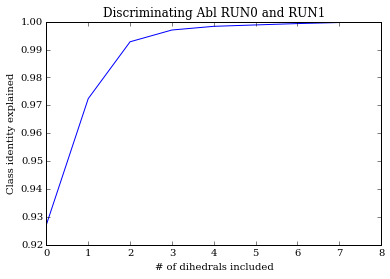

In [46]:
plt.plot(np.cumsum(sorted(dt.feature_importances_[dt.feature_importances_!=0])[::-1]))
plt.xlabel('# of dihedrals included')
plt.ylabel('Class identity explained')
plt.title('Discriminating Abl RUN0 and RUN1')

In [121]:
dt.tree_

In [59]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1',C=0.02)
lr.fit(X_bin[::10],y_bin[::10])
lr.score(X_bin,y_bin)

1.0

In [60]:
np.sum(lr.coef_!=0)

17

In [69]:
lr.coef_!=0

for i in np.arange(len(lr.coef_.flatten()))[lr.coef_.flatten()!=0]:
    print(dihedral_to_string(atom_list[i],top))

TYR264-C,SER265-N,SER265-CA,SER265-C
GLU275-C,ASP276-N,ASP276-CA,ASP276-C
PHE382-C,GLY383-N,GLY383-CA,GLY383-C
GLU275-N,GLU275-CA,GLU275-C,ASP276-N
GLU275-N,GLU275-CA,GLU275-C,ASP276-N
GLU279-N,GLU279-CA,GLU279-C,VAL280-N
VAL289-N,VAL289-CA,VAL289-C,MET290-N
PHE382-N,PHE382-CA,PHE382-C,GLY383-N
ASP391-N,ASP391-CA,ASP391-C,THR392-N
THR392-N,THR392-CA,THR392-C,TYR393-N
LYS404-N,LYS404-CA,LYS404-CB,LYS404-CG
GLU409-N,GLU409-CA,GLU409-CB,GLU409-CG
ARG362-N,ARG362-CA,ARG362-CB,ARG362-CG
VAL379-N,VAL379-CA,VAL379-CB,VAL379-CG1
TYR257-CA,TYR257-CB,TYR257-CG,TYR257-CD1
GLU409-CA,GLU409-CB,GLU409-CG,GLU409-CD
TYR456-CA,TYR456-CB,TYR456-CG,TYR456-CD1


In [61]:
preds = lr.predict_log_proba(X_bin)

In [62]:
preds.shape

(185912, 2)

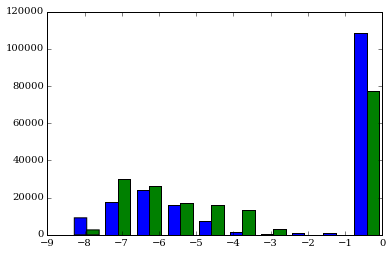

In [63]:
plt.hist(preds);

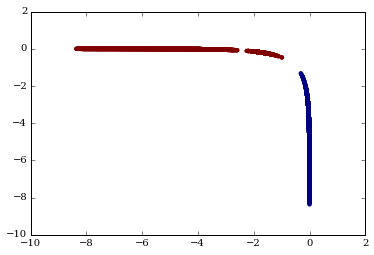

In [64]:
plt.scatter(preds[:,0],preds[:,1],c=y_bin,linewidths=0)

In [65]:
atom_list[lr.coef_.flatten()!=0]

array([[ 375,  377,  379,  386],
       [ 553,  555,  557,  565],
       [2293, 2295, 2297, 2300],
       [ 540,  542,  553,  555],
       [ 540,  542,  553,  555],
       [ 598,  600,  611,  613],
       [ 755,  757,  769,  771],
       [2275, 2277, 2293, 2295],
       [2413, 2415, 2423, 2425],
       [2425, 2427, 2437, 2439],
       [2603, 2605, 2607, 2610],
       [2687, 2689, 2691, 2694],
       [1968, 1970, 1972, 1975],
       [2237, 2239, 2241, 2243],
       [ 231,  233,  236,  237],
       [2689, 2691, 2694, 2697],
       [3438, 3440, 3443, 3444]])

In [109]:
# can use LDA-- side effect: create a trajectory-separating 2D plot again, similar to Chaya's analysis of the GPCR sims?
from sklearn.lda import LDA
lda = LDA(n_components=2)

X_bin_ = X_bin[:,dt.feature_importances_!=0]
lda.fit(X_bin_,y_bin)

LDA(n_components=3, priors=None, shrinkage=None, solver='svd',
  store_covariance=False, tol=0.0001)

In [110]:
lda.score(X_bin_,y_bin)

0.98174405094883599

In [111]:
X_prime = lda.transform(X_bin_)

In [112]:
X_bin_.shape

(185912, 25)

In [113]:
X_prime.shape # oops, why 1D when n_components=2?

(185912, 1)

In [66]:
# discretize just the DFG-flip dihedral?

DFG = [2257,2255,2265,2270]
dihedral_to_string(DFG,top)

'ALA380-CB,ALA380-CA,ASP381-CA,ASP381-CG'

In [147]:
dfg_flip_coordinates = []

for fname in fnames:
    try:
        x = md.compute_dihedrals(md.load(fname),[DFG])
        dfg_flip_coordinates.append(x)
    except:
        pass

In [148]:
def create_overlap_matrix(dtrajs):
    overlap_matrix = np.zeros((len(dtrajs),len(dtrajs)))

    sets = [set(traj) for traj in dtrajs]

    for i in range(len(overlap_matrix)):
        for j in range(len(overlap_matrix)):
            overlap_matrix[i,j] = len(sets[i].intersection(sets[j]))
    
    return overlap_matrix

def find_run_boundaries(fnames):
    runs = []
    for fname in fnames:
        i = fname.find('run')
        j = fname.find('-')
        runs.append(int(fname[i+3:j]))
    
    ticks = []
    for i in range(1,len(runs)):
        if runs[i] != runs[i-1]:
            ticks.append(i-1)
    return ticks

def plot_binary_overlap_matrix(overlap_matrix,name='Abl'):
    plt.imshow(overlap_matrix>0,interpolation='none',cmap='Blues');
    #plt.colorbar()
    plt.xlabel('Clones (grouped by run)')
    plt.ylabel('Clones (grouped by run)')
    plt.title(name+': Presence/absence of discrete state overlap among clones')
    ticks = find_run_boundaries(fnames)
    labels = ['']*len(ticks)
    plt.xticks(ticks,labels)
    plt.yticks(ticks,labels)
    plt.grid(linestyle='-',color='grey',alpha=0.1)

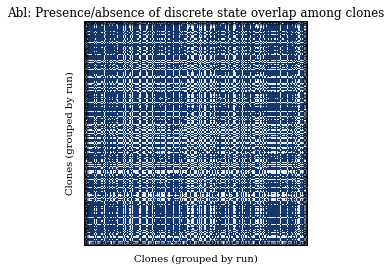

In [151]:
from msmbuilder.cluster import NDGrid
ndgrid = NDGrid(n_bins_per_feature=100)
dtrajs = ndgrid.fit_transform(dfg_flip_coordinates)

overlap_matrix = create_overlap_matrix(dtrajs)
plot_binary_overlap_matrix(overlap_matrix,'Abl')
# finely discretizing only the DFG-flip coordinate as identified in octomore is insufficient to 

In [ ]:
# create a separate interface for every pair of runs?

In [ ]:
for i in range(n_runs):
    for j in range(i):
        if i != j:
            dt = DecisionTreeClassifier(criterion='entropy',max_depth=3)
            bitmask = ((y==i)+(y==j))!=0
            dt.fit(X_[bitmask][::stride],y[bitmask][::stride])
            score = dt.score(X_[bitmask],y[bitmask])
            discriminators.append(((i,j),dt,score))
            print(score)

In [125]:
# now do this with inter-residue distances?

residues_of_interest = [328,
                        317,
                        408,
                        387,
                        447,
                        339,
                        341,
                        326,
                        284,
                        296,
                        396,
                        395,
                        397,
                        349,
                        454,
                        458
                       ]

residue_ids = np.array(residues_of_interest)-270

In [126]:
respairs = []
for i in range(len(residue_ids)):
    for j in range(i):
        if i!=j:
            respairs.append((i,j))

In [127]:
len(traj)

1

In [131]:
len(md.compute_contacts(traj,respairs,'closest')[0][0])

120

In [132]:
traj = md.load(fnames[0])

In [135]:
X_contacts = []
y_contacts = []
for fname in fnames:
    try:
        x = md.compute_contacts(traj,respairs,'closest')[0]
        X_contacts.append(x)
        i = fname.find('run')
        j = fname.find('-')
        run = (int(fname[i+3:j]))
        y_contacts.append(np.ones(len(x))*run)
    except:
        pass

In [136]:
X_contacts[0].shape

(3280, 120)

In [137]:
X_contacts_ = np.vstack(X_contacts)

In [138]:
y_contacts_ = np.hstack(y_contacts)

In [141]:
dt = DecisionTreeClassifier(criterion='entropy',max_depth=5)
dt.fit(X_contacts_[::2],y_contacts_[::2])

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

In [142]:
dt.score(X_contacts_,y_contacts_)

0.079051383399209488

In [ ]:
# ooh, that didn't work too well-- unlucky choice of respairs?

In [ ]:
# construct interface sets surrounding metastable cores
# gaussians?
# planes?
# boxes?